<h1>Audio Chord Estimation using Neural Networks</h1>
<h4>Theofanis Aslanidis</h4>
    

<h3>Abstract</h3>
In this project, we are going to explore the use of deep neural networks for recognizing audio chords, using the Isophonics dataset - the one that is used on MIREX.<br>
For the first steps of the implementation, I'm using a test-dataset only with one album, because the memory needed is very large, due to the one hot representation. So I'm using only the album "<i>Let it Be</i>" until I implement a batch training, where I won't need to load all data on memory at once.<br><br>
<i>In order to run the notebook you will need my dataset, and ~32GB ram</i>

In [1]:
import sys
# do this only once
sys.path.append('./src/audio-processing/')
sys.path.append('./src/data-processing/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#python input/output and regex
import re
import os
from pathlib import Path

#signal processing libraries
from scipy.io import wavfile
from scipy import signal

#sklearn for normalization
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#tensorflow
import tensorflow as tf
from tensorflow import keras

#padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

#librosa
import librosa

#import custom modules
import filters
import spectrograms
import audiofiles
import annotation_processing

<h3>Audio File pre-processing</h3>

Script to Convert <b>mp3 files to wav</b>

In [4]:
audiofiles.mp3_to_wav()

Script to Convert files from <b>stereo to mono</b>

In [81]:
audiofiles.stereo_to_mono()

<h3>Loading Datasets</h3>
<h4>Annotations</h4>

From the <b>isophonics</b> dataset, in the chordlab folder, there are all the annotations we need.<br>
Read all those chordlab files as <b>pandas dataframes</b> and store them in a dictionary of dataframes.

In [3]:
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Big-Dataset/The Beatles').glob('**/chordlab/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab['The Beatles']): 
        Chordlab['The Beatles'][album] = {}
        
    Chordlab['The Beatles'][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)

For all the tracks we have the annotations, we need to load the appropriate audio track for each one, create the spectrogram, and store the (time, frequency, power) vector.<br>
<b>Steps:</b>
<ul>
    <li> Browse to those wav files
    <li> Read with wavfile from SciPy
    <li> Create spectrogram with signal spectrogram
</ul>

<h4>Spectrograms</h4>
<br>
<b>We are going to use fewer timesteps in order to save memory.</b>
<br>We will try and take the exact timestep when a chord changes and its neighborhood we can see some results.<br><br>
<b>OBSERVATION!</b> Maybe classifying every time step that we did is wrong, and we should find out when a chord changes and from the various classifications of its neighborhood, we decide the final Chord for each interval.<br>

- Creating Spectrograms with different timesteps
- Creating Spectrograms with more timesteps
- Creating Spectrograms with neighborhoods on chords changes

In [4]:
### get all audio files and create spectrogram for each track
audiofiles_path='Audiofiles/The Beatles'
n_fft=2048
nperseg=2048
Spectrograms, frequencies_num = spectrograms.create_spectrograms(n_fft, nperseg, audiofiles_path)

In [5]:
print ('Number of unique frequncies: ', frequencies_num)

Number of unique frequncies:  1025


Resulting spectrograms contain info for 1025 frequency range

<h3>Data preprocessing, convert data into input that I can feed in the neural network</h3>
<br>
<ol>
    <li> For training we should have all anotations, together with their spectrograms'
    <li> For testing all the spectrograms of the test dataset
</ol>
<br>
<b>Shape of the final training data</b>
<ul>
    <li>X_train, Y_train = [spectrograms], [annotations]
    <li>X_test = [spectrograms_test]
</ul>
<br>
<b>Steps to convert data from dictionaries into data that I can feed in the neural network</b>
<br>
Firstly, I'm thinking I have to create a vocabulary for the chords.<br>
Such as the <b>word2vec</b> representation we use on NLP, we will need in this project something similar.<br>
<b>Chord:</b><br>
C -> 0<br>
C#\Db -> 1<br>
D -> 2<br>
D#\Eb -> 3<br>
E -> 4<br>
F -> 5<br>
F#\Gb -> 6<br>
etc.<br>
<br>
<b>Mode:</b>
Minor Chord: 0<br>
Major Chord: 1<br>
<br>
<b>Sustained: </b>
1,2,3,4,5,6,7,8,9<br>

As it seems, the combinations can vary.<br>
So we can:
<ul>
    <li>try an encoding(hashing) for each chord, and when we stumble upon each chord we hash it to a unique combination that goes into a vector.</li>
    <li>we can iterate all train data, and for each chord we see, create a "slot" in our dictionary. So we have a dictionary with all the chords that appear on the dataset. That way we can work with a <b>one hot</b> representation.</li>
 </ul>

In [6]:
### Load all chords in a dictionary
Chords = []
for album in Chordlab['The Beatles'].keys():
    for track_no in Chordlab['The Beatles'][album].keys():
        for index, row in Chordlab['The Beatles'][album][track_no].iterrows():
            if row['Chord'] not in Chords: Chords.append(row['Chord'])
                
### How many chords do we have in our dataset?
print ("Unique Chords in our Dataset: ",len(Chords))

Unique Chords in our Dataset:  407


For one album we have 68 Chords, so our vectors are going to be <b>one hot vectors</b> of 68 size. (67 zeros and 1 one)<br>
Create one hot encodings of the chords, with <b>pandas Series + get_dummies</b><br>
<h4>One Hot Encodings</h4>
<br>
With <b>pandas</b>:

In [6]:
num_chords = len(Chords)
s = pd.Series(Chords)
OneHotEncodings = pd.get_dummies(s)

With <b>Sklearn</b>:<br>
<i>(which provides us with inverse transformation, for the results.)</i>

In [7]:
encoder = OneHotEncoder()
encoder.fit(np.array(pd.Series(Chords)).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

<h3>Indexing chords with timestamps</h3>

<img src="images/Vector_flow.png" width="800" />

<caption><center> <b>Figure 1</b>: Annotation Data Processing.</center></caption>

Now we have to align the <b>timing of the chords</b> with the <b>times array</b><br>
To achieve that lets try to convert the timing - chords data of the .lab files in the same representation as the spectrograms data.<br>
We will keep the same timeline (times), and using the timing<br>
<b><font color='red'>Warning</font>: This is computational expensive for the cpu. If you have it ready, you can load it below with pickle.</b><br> 

In [27]:
Artist='The Beatles'
Timeseries=Spectrograms
chords2vec = {}
for album in Chordlab[Artist].keys():
    chords2vec[album] = {}
    for track_no in Chordlab[Artist][album].keys():
        times = Timeseries[Artist][album][track_no]['times']
        df_rows = Chordlab[Artist][album][track_no].itertuples()
        index = 0
        max_len = len(Chordlab[Artist][album][track_no])
        vector = np.empty((len(Chords),))
        row = next(df_rows)
        for timestamp in times:
            if ((index + 1) < max_len) & (timestamp >= row[2]):
                index += 1
                row = next(df_rows)
            vector = np.column_stack((vector, encoder.transform([[row[3]]]).toarray()[0]))
        chords2vec[album][track_no] = vector
        # print(album, ': track ', track_no, ' completed')

# Take care fo the one extra row in the beginning of the array
for album in chords2vec.keys():
    for track_no in chords2vec[album].keys():
        chords2vec[album][track_no] = np.delete(chords2vec[album][track_no], 0, 1)

Now we have our 4D data ready in a dictionary to go into our model for training.<br>
3 dimensions (times, frequencies, power) will go as X_train and chords2vec will go as Y_train<br><br>

<b>Store - Load Data with pickle</b>

In [28]:
### STORE
import pickle

with open('full_indexed.pickle', 'wb') as handle:
    pickle.dump(chords2vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
### LOAD
import pickle

with open('full_indexed.pickle', 'rb') as handle:
    chords2vec = pickle.load(handle)

## Train/Test Data Initialization
<br>
After appending all the data together, we slice them into batches, as shown below:<br>
(Example is for the X_train, we do exactly the same for the Y_train - chord annotations.)
<br>

### Approach 1
- Batch per song with padding sequences

In [9]:
x_train = []
y_train = []
test_track_no = '06'
for album in chords2vec.keys():
    for track_no in chords2vec[album].keys():
        # test data
        if track_no == test_track_no and album == '12_-_Let_It_Be':
            x_test = Spectrograms['The Beatles'][album][track_no]['powerSpectrum'].T
            y_test = chords2vec[album][track_no].T
            continue
        # train data
        x_train.append(Spectrograms['The Beatles'][album][track_no]['powerSpectrum'].T)
        y_train.append(chords2vec[album][track_no].T)
        
maxlen = len(max(x_train, key=len))

x_train = pad_sequences(x_train, maxlen=maxlen, padding='post')
y_train = pad_sequences(y_train, maxlen=maxlen, padding='post')
x_test = pad_sequences([x_test], maxlen=maxlen, padding='post')
y_test = pad_sequences([y_test], maxlen=maxlen, padding='post')

<h4>Normalization</h4>

In [10]:
scalers = {}
for i in range(x_train.shape[0]):
    scalers[i] = StandardScaler()
    x_train[i, :, :] = scalers[i].fit_transform(x_train[i, :, :]) 

test_scaler = StandardScaler()
x_test[0, :, :] = test_scaler.fit_transform(x_test[0, :, :])

# due to some error in matmul
x_test = tf.cast(x_test, tf.float32)

In [11]:
chunk_size = maxlen

### Approach 2
- Stack all data and then slice them into chunks

<img src="images/slicing.png" width="800" />

<caption><center> <b>Figure 2</b>: Slicing data into Batches.</center></caption>

In this article the following is stated.<br>
https://tm3.ghost.io/2018/09/05/building-lstms-for-time-series-forecasting/<br>
<i>"Instead of one sequence of 1870, you could have many sequences of let's say 20. Your sequences should be overlapping windows `[0-20], [1-21], [2-22]`, etc, so your final shape would be something like `(1850, 20, 14)`.Same process for your test data. Break into subsequences of the same length as training. You will have to play around with finding what a good subsequence length is. It is extremely important to have many different ways of slicing your data. If you train on just one super long sequence it will probably not learn anything interesting."</i>

<h4>1. Constructing numpy arrays</h4>

In [9]:
x_initial_train = np.zeros((1,frequencies_num))
y_initial_train = np.zeros((1,len(Chords)))
x_initial_test = np.zeros((1,frequencies_num))
y_initial_test = np.zeros((1,len(Chords)))
test_track_no = '06'
for album in chords2vec.keys():
    for track_no in chords2vec[album].keys():
        if track_no != test_track_no or album != '12_-_Let_It_Be':
            y_initial_train = np.append(y_initial_train, chords2vec[album][track_no].T, axis = 0)
            x_initial_train = np.append(x_initial_train, Spectrograms['The Beatles'][album][track_no]['powerSpectrum'].T, axis = 0)
        else:
            y_initial_test = np.append(y_initial_test, chords2vec[album][track_no].T, axis = 0)
            x_initial_test = np.append(x_initial_test, Spectrograms['The Beatles'][album][track_no]['powerSpectrum'].T, axis = 0)

print (x_initial_train.shape, y_initial_train.shape)

(713015, 1025) (713015, 407)


<b>If you have limited RAM clear this 4GB dictionary for memory issues !</b>

In [69]:
#spectrogram dict is no longer necessary
Spectrograms.clear()

<h4>2. Normalization</h4>

In [10]:
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(x_initial_train)
# transform training dataset
x_initial_train = scaler.transform(x_initial_train)

# fit scaler on training dataset
scaler.fit(x_initial_test)
# transform training dataset
x_initial_test = scaler.transform(x_initial_test)

<h4>3. Slicing in batches of timeseries and for the LSTM</h4>

In [11]:
# Find the chunk size
chunk_size = 300

In [12]:
# Slicing
x_train = np.zeros((1,chunk_size,frequencies_num)) #num of frequencies
y_train = np.zeros((1,chunk_size,len(Chords)))

timestep = 0
chunks = x_initial_train.shape[0]
while timestep < chunks :
    if (chunks - timestep) > chunk_size:
        batch_x = np.resize(x_initial_train[timestep:timestep+chunk_size,:], (1, chunk_size, frequencies_num)) #num of frequencies
        x_train = np.append(x_train, batch_x, axis = 0)
        batch_y = np.resize(y_initial_train[timestep:timestep+chunk_size,:], (1, chunk_size,len(Chords)))
        y_train = np.append(y_train, batch_y, axis = 0)
    else:
        batch_x = x_initial_train[timestep:,:]
        batch_y = y_initial_train[timestep:,:]
        for step in range (0, chunk_size + timestep - chunks):
            batch_x = np.vstack((batch_x, np.zeros((1,frequencies_num))))
            batch_y = np.vstack((batch_y, encoder.transform([['N']]).toarray()[0]))
        x_train = np.append(x_train, np.array([batch_x]), axis = 0)
        y_train = np.append(y_train, np.array([batch_y]), axis = 0)
    timestep += chunk_size
    
print (x_train.shape)
print (y_train.shape)

#delete first line batch of array because its zeros

(2378, 300, 1025)
(2378, 300, 407)


In [13]:
# Slicing
x_test = np.zeros((1,chunk_size,frequencies_num)) #num of frequencies
y_test = np.zeros((1,chunk_size,len(Chords)))

timestep = 0
chunks = x_initial_test.shape[0]
while timestep < chunks :
    if (chunks - timestep) > chunk_size:
        batch_x = np.resize(x_initial_test[timestep:timestep+chunk_size,:], (1, chunk_size, frequencies_num)) #num of frequencies
        x_test = np.append(x_test, batch_x, axis = 0)
        batch_y = np.resize(y_initial_test[timestep:timestep+chunk_size,:], (1, chunk_size,len(Chords)))
        y_test = np.append(y_test, batch_y, axis = 0)
    else:
        batch_x = x_initial_test[timestep:,:]
        batch_y = y_initial_test[timestep:,:]
        for step in range (0, chunk_size + timestep - chunks):
            batch_x = np.vstack((batch_x, np.zeros((1,frequencies_num))))
            batch_y = np.vstack((batch_y, encoder.transform([['N']]).toarray()[0]))
        x_test = np.append(x_test, np.array([batch_x]), axis = 0)
        y_test = np.append(y_test, np.array([batch_y]), axis = 0)
    timestep += chunk_size
    
print (x_test.shape)
print (y_test.shape)

#delete first line batch of array because its zeros

(21, 300, 1025)
(21, 300, 407)


Delete the first row from every array because of the append, which left it all zeros.

In [14]:
x_train = np.delete(x_train,0,0)
y_train = np.delete(y_train,0,0)
x_test = np.delete(x_test,0,0)
y_test = np.delete(y_test,0,0)

In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2377, 300, 1025)
(2377, 300, 407)
(20, 300, 1025)
(20, 300, 407)


## Chord Embeddings

In [16]:
def chord_embeddings(Chordlab, Timeseries):
    Chord_Progressions = []
    slice_count = 0
    progression = []
    for Artist in Chordlab.keys():
        for album in Chordlab[Artist].keys():
            for track_no in Chordlab[Artist][album].keys():
                if ((track_no == test_track_no) and (album == '12_-_Let_It_Be')): continue
                times = Timeseries[Artist][album][track_no]['times']
                df_rows = Chordlab[Artist][album][track_no].itertuples()
                index = 0
                max_len = len(Chordlab[Artist][album][track_no])
                vector = np.empty((len(Chords),))
                row = next(df_rows)
                for timestamp in times:
                    
                    if ((index + 1) < max_len) & (timestamp >= row[2]):
                        index += 1
                        row = next(df_rows)
                       
                    #not filtering silences
                    slice_count += 1
                    progression.append(row[3])
                    
                    if slice_count % chunk_size == 0:
                        Chord_Progressions.append(progression)
                        progression = []
    
    return Chord_Progressions

#### Build chord progressions

In [17]:
Chord_Progressions = chord_embeddings(Chordlab, Spectrograms)

**List of sequences**

Transform <'list of lists'> with the progressions into a <'ist of sentences'> separated by whitespace.

In [18]:
Chord_Sentences = []
for progression_set in Chord_Progressions:
    progression_sentence = ' '.join(progression_set)
    Chord_Sentences.append(progression_sentence)

**From sentences of 'C G D' -> sentences of one hot representation**

In [19]:
embedded_progressions = [one_hot(progression_sentence, len(Chords)) for progression_sentence in Chord_Sentences]

**Padding**

In [20]:
#padding
maxLen = chunk_size
embeddings_train = pad_sequences(embedded_progressions, maxlen=maxLen, padding='post')
embeddings_test = np.zeros((20,chunk_size))

In [22]:
# there is a bug where it comes one row short, temporary fix
embeddings_train = np.vstack((embeddings_train, np.zeros((1,chunk_size))))

In [23]:
print (embeddings_train.shape)
print (embeddings_test.shape)

(2377, 300)
(20, 300)


# Neural Network

Let's play with various RNNs with tensorflow, we will play with combinations of:
- LSTM
- Bidirectional LSTM
- GRU
- Convolutional Neural Net
- Embeddings

In [16]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, GRU, concatenate, Conv1D, Conv2D, Flatten,MaxPooling1D, LocallyConnected1D, Activation, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, RandomUniform

### Single Input Models

> **Simple 2 Layer Bidirectional LSTM**
1. Data -> 2 Layers BLSTM
2. output -> Dense -> predictions

In [17]:
def BLSTM_2Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num), name='main_input')
    
    #BLSTM
    x = Bidirectional(LSTM(units = 40, 
                           batch_input_shape = (batch_size, timesteps, frequencies_num),
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           recurrent_dropout = 0.25,
                           return_sequences = True))(main_input)
    x = Dropout(0.5)(x)
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 40,
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           recurrent_dropout = 0.25,
                           return_sequences=True))(x)
    x = Dropout(0.5)(x)
    #Dense for classification
    x = Dense(chords_num)(x)
    main_output = Activation('softmax')(x)
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

> **Convolutions as features**
1. Data -> CNN -> out1
2. Data -> BLSTM -> out2
3. out1, out2 -> BLSTM -> output
4. output -> Dense -> output

In [108]:
def Conv1D_Merge_BLSTM_2Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num), name='main_input')
    
    #CNN
    convs = Conv1D(filters=150, 
                   kernel_size=5, 
                   padding='same')(main_input)
    
    #BLSTM
    x = Bidirectional(LSTM(units = 50, 
                           batch_input_shape = (batch_size, timesteps, frequencies_num),
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           recurrent_dropout = 0.25,
                           return_sequences = True))(main_input)
    x = Dropout(0.5)(x)
    #merge CNN and LSTM output
    merged = concatenate([x, convs], axis=-1)
    
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 50,
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           recurrent_dropout = 0.25,
                           return_sequences=True))(merged)
    x = Dropout(0.5)(x)
    #Dense for classification
    x = Dense(chords_num)(x)
    main_output = Activation('softmax')(x)
    
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

> **Sequence to Conv**
1. Data -> Convolutions -> c
2. c pass through 2 Layers of BLSTM
3. x -> Dense -> predictions

In [51]:
def Conv1D_BLSTM_2Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num), name='main_input')
    
    #Convolutional Layer
    c = Conv1D(filters=150, 
               kernel_size=5, 
               padding='same')(main_input)
    #BLSTM
    x = Bidirectional(LSTM(units = 40, 
                           batch_input_shape = (batch_size, timesteps, frequencies_num),
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           recurrent_dropout = 0.25,
                           return_sequences = True))(c)
    x = Dropout(0.4)(x)
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 40,
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           recurrent_dropout = 0.25,
                           return_sequences=True))(x)
    x = Dropout(0.4)(x)
    #Dense for classification
    main_output = Dense(chords_num, activation='softmax')(x)
    
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

> **Conv1D through BLSTM**
1. Data -> CNN -> convs -> BLSTM -> out1
2. Data -> BLSTM -> out2
3. out1,out2 -> BLSTM -> output
4. output -> Dense -> predictions

In [116]:
def Conv1D_BLSTM_2Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num), name='main_input')

    #Convolutional Layer
    c = Conv1D(filters=100, 
               kernel_size=5, 
               padding='same')(main_input)
    #BLSTM on Convolutions
    out1 = Bidirectional(LSTM(units=50, 
                              batch_input_shape = (batch_size, timesteps, frequencies_num), 
                              return_sequences=True))(c)
    out1 = Dropout(0.5)(out1)
    #BLSTM on inputs
    out2 = Bidirectional(LSTM(units=50, 
                              batch_input_shape = (batch_size, timesteps, frequencies_num), 
                              return_sequences=True))(main_input)
    out2 = Dropout(0.5)(out2)
    #BLSTM
    merged = concatenate([out1, out2], axis=-1)
    x = Bidirectional(LSTM(units=50, 
                           batch_input_shape = (batch_size, timesteps, frequencies_num), 
                           return_sequences=True))(merged)
    x = Dropout(0.5)(x)
    #Dense for classification
    main_output = Dense(chords_num, activation='softmax')(x)
    
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

### Double input models

In [26]:
# model with full concatenation
def Embeddings_ΒLSTM_Conv1D_2Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num), name='main_input')
    embeddings_input = Input(shape=(maxLen,), name='embeddings_input')
    
    #Embedding layer
    e = Embedding(input_dim=chords_num, 
                  output_dim=100, 
                  input_length=maxLen)(embeddings_input)
    #Convolutional Layer
    c = Conv1D(filters=100, 
               kernel_size=3, 
               padding='same')(main_input)
    #BLSTM
    x = Bidirectional(LSTM(units=128, 
                           batch_input_shape = (batch_size, timesteps, frequencies_num),
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           return_sequences=True))(main_input)
    x = Dropout(0.4)(x)
    #Merge the 2 models
    merged = concatenate([x, c, e], axis=-1)
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units=128,
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           return_sequences=True))(merged)
    x = Dropout(0.5)(x)
    #Dense for classification
    main_output = Dense(chords_num, activation='softmax')(x)
    
    #model
    model = Model(inputs=[main_input, embeddings_input], outputs=[main_output])

    return model

In [85]:
# model with Conv1d + X -> LSTM -> Embeddings + X -> LSTM -> Dense 
def Conv1D_LSTM_Embeddings_2Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num), name='main_input')
    embeddings_input = Input(shape=(maxLen,), name='embeddings_input')
    
    #Embedding layer
    e = Embedding(input_dim=chords_num, output_dim=50, input_length=maxLen)(embeddings_input)
    #Convolutional Layer
    c = Conv1D(filters=100, kernel_size=3, padding='same')(main_input)
    #BLSTM
    merged = concatenate([main_input, c], axis=-1)
    x = Bidirectional(LSTM(128, batch_input_shape = (batch_size, timesteps, frequencies_num), return_sequences=True))(merged)
    x = Dropout(0.5)(x)
    #Merge the 2 models
    merged = concatenate([x, e], axis=-1)
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(64, return_sequences=True))(merged)
    x = Dropout(0.5)(x)
    #Dense for classification
    main_output = Dense(chords_num, activation='softmax')(x)
    
    #model
    model = Model(inputs=[main_input, embeddings_input], outputs=[main_output])

    return model

In [42]:
# model with LSTM -> Conv1d + X -> LSTM -> X + e -> LSTM -> Dense
def Conv1D_BLSTM_Embeddings_3Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num), name='main_input')
    embeddings_input = Input(shape=(maxLen,), name='embeddings_input')
    
    #Embedding layer
    e = Embedding(input_dim=chords_num, output_dim=50, input_length=maxLen)(embeddings_input)
    #Convolutional Layer
    c = Conv1D(filters=100, kernel_size=3, padding='same')(main_input)
    #BLSTM
    x = Bidirectional(LSTM(256, batch_input_shape = (batch_size, timesteps, frequencies_num), return_sequences=True))(main_input)
    x = Dropout(0.4)(x)
    #Merge the 2 models
    merged = concatenate([x, c], axis=-1)
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(128, return_sequences=True))(merged)
    x = Dropout(0.4)(x)
    #3rd layer
    merged = concatenate([x, e], axis=-1)
    x = Bidirectional(LSTM(64, return_sequences=True))(merged)
    #Dense for classification
    main_output = Dense(chords_num, activation='softmax')(x)

    #model
    model = Model(inputs=[main_input, embeddings_input], outputs=[main_output])

    return model

#### Single Input Model Call

In [18]:
# Fitting on a Conv1D with 256 filters feeding to a 2 layer BLSTM with 256 cells
epochs = 10
batch_size = 32

model = BLSTM_2Layer(len(Chords), frequencies_num, chunk_size, batch_size)

SGD_Optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9)
Adam_Optimizer = keras.optimizers.Adam()
AdaGrad_Optimizer = keras.optimizers.Adagrad()

model.compile(optimizer=Adam_Optimizer,
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


# train
test_data = x_test
history_callback = model.fit(x_train, y_train, epochs=epochs,
          validation_data=(x_test, y_test), batch_size=batch_size, verbose=1)

model.summary()

Train on 2377 samples, validate on 20 samples
Epoch 1/10
2377/2377 [==============================] - 25s 10ms/sample - loss: 5.4537 - accuracy: 0.0962 - val_loss: 3.8939 - val_accuracy: 0.0098
Epoch 2/10
2377/2377 [==============================] - 21s 9ms/sample - loss: 3.9368 - accuracy: 0.1753 - val_loss: 3.4846 - val_accuracy: 0.1713
Epoch 3/10
2377/2377 [==============================] - 21s 9ms/sample - loss: 3.4302 - accuracy: 0.2906 - val_loss: 3.1051 - val_accuracy: 0.2712
Epoch 4/10
2377/2377 [==============================] - 21s 9ms/sample - loss: 3.0806 - accuracy: 0.3557 - val_loss: 3.3657 - val_accuracy: 0.2445
Epoch 5/10
2377/2377 [==============================] - 21s 9ms/sample - loss: 2.7865 - accuracy: 0.4092 - val_loss: 4.2361 - val_accuracy: 0.2198
Epoch 6/10
2377/2377 [==============================] - 21s 9ms/sample - loss: 2.5706 - accuracy: 0.4482 - val_loss: 3.3339 - val_accuracy: 0.2780
Epoch 7/10
2377/2377 [==============================] - 21s 9ms/sample 

In [19]:
# evaluate on test set
loss, accuracy = model.evaluate([x_test], y_test, verbose=0)
print("Final test loss: ", loss, " and accuracy :", 100*accuracy, "%")

Final test loss:  3.427684783935547  and accuracy : 29.399999976158142 %


#### Double Input Model Call

In [43]:
epochs = 15
batch_size = 32

model = Conv1D_BLSTM_Embeddings_3Layer(len(Chords), frequencies_num, chunk_size, batch_size)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# train
test_data = [x_test, embeddings_test]
history_callback_embeddings = model.fit([x_train, embeddings_train], [y_train], epochs=epochs,
          validation_data=([x_test, embeddings_test], y_test), batch_size=batch_size, verbose=1)

model.summary()

Train on 2377 samples, validate on 20 samples
Epoch 1/15
2377/2377 [==============================] - 125s 52ms/sample - loss: 4.0609 - accuracy: 0.1589 - val_loss: 3.2889 - val_accuracy: 0.1440
Epoch 2/15
2377/2377 [==============================] - 119s 50ms/sample - loss: 3.2818 - accuracy: 0.3313 - val_loss: 3.6394 - val_accuracy: 0.2027
Epoch 3/15
2377/2377 [==============================] - 116s 49ms/sample - loss: 2.7275 - accuracy: 0.4378 - val_loss: 3.5940 - val_accuracy: 0.2238
Epoch 4/15
2377/2377 [==============================] - 116s 49ms/sample - loss: 2.3456 - accuracy: 0.5070 - val_loss: 4.1959 - val_accuracy: 0.1943
Epoch 5/15
2377/2377 [==============================] - 117s 49ms/sample - loss: 2.0252 - accuracy: 0.5713 - val_loss: 4.2321 - val_accuracy: 0.2423
Epoch 6/15
2377/2377 [==============================] - 116s 49ms/sample - loss: 1.7952 - accuracy: 0.6092 - val_loss: 3.8614 - val_accuracy: 0.2598
Epoch 7/15
2377/2377 [==============================] - 119s

In [44]:
# evaluate on test set
loss, accuracy = model.evaluate(test_data, y_test, verbose=0)
print("Final test loss: ", loss, " and accuracy :", 100*accuracy, "%")

Final test loss:  4.666597366333008  and accuracy : 21.73333317041397 %


<h3>Transform predictions into Chords</h3>
<br>
Get the resulting one hot encodings, map to the appropriate chords and write the result<br>

In [20]:
predictions = model.predict(test_data, batch_size=batch_size, use_multiprocessing=True)

In [21]:
estimated_chord_list = []
real_chord_list = Chordlab['The Beatles']['12_-_Let_It_Be'][test_track_no]

for batch_chords in predictions:
    for chord in batch_chords:
        estimated_chord_list.append(encoder.inverse_transform([chord]).reshape(1,)[0])
        
df_predictions = pd.DataFrame({'Estimated Chords' : estimated_chord_list})
display(df_predictions)

,Estimated Chords
0,A
1,A
2,A
3,A
4,A
...,...
5995,E
5996,E
5997,E
5998,E


### Plot Model Efficiency

#### Single Input model

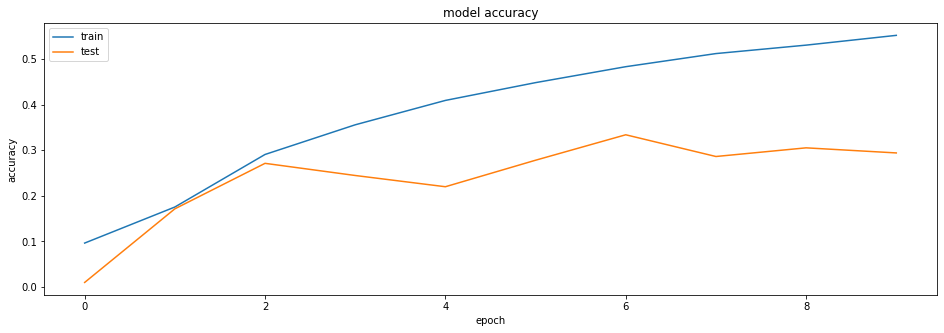

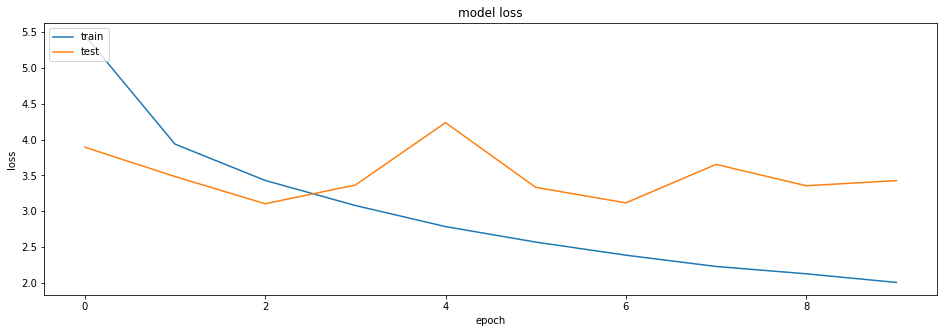

In [22]:
plt.figure(figsize=(16,5))
# summarize history for accuracy
plt.plot(history_callback.history['accuracy'])
plt.plot(history_callback.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize=(16,5))
# summarize history for loss
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Double input with embeddings

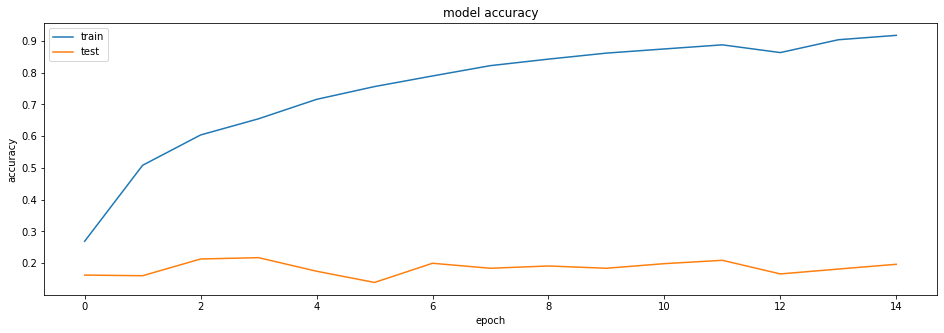

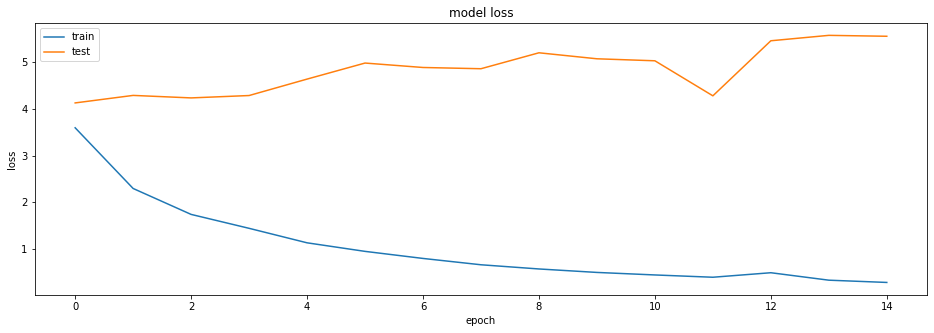

In [47]:
plt.figure(figsize=(16,5))
# summarize history for accuracy
plt.plot(history_callback_embeddigns.history['accuracy'])
plt.plot(history_callback_embeddigns.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize=(16,5))
# summarize history for loss
plt.plot(history_callback_embeddigns.history['loss'])
plt.plot(history_callback_embeddigns.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<h3>Model 2</h3>
<br>
We can see the predictions are quite messy. Some random chords appear for < 5 timesteps, so we can build a model to smooth those predictions.

### Notes
* Maybe slicing is not a good idea for the tracks -> use padding with 'N'